### Download Data

The data is taken from http://archive.ics.uci.edu/ml/machine-learning-databases/00240/, but you can have it in the form of the UCI-HAR-Dataset.zip.

Extract it to the folder of your notebook with the solution (or suitably adjust the paths to training and test data specified below (TRAIN, TEST).  

Spcifically, the split into training and testing data is already done. The dataset contains 7352 training and 2947 test samples.  

Each sample consists of 9 timeseries of float values, each of length 128.

The 9 timeseries are collected by an accelerometer and a gyroscope that contain information about the motion and the orientation, respectively.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import os

### Load Data

In [4]:
# Useful Constants
TRAIN = "../data/UCI_HAR_Dataset/train/"
TEST = "../data/UCI_HAR_Dataset/test/"

# x-values, 'signals'
# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]
X_train_signals_paths = [TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES]
X_test_signals_paths =  [TEST  + "Inertial Signals/" + signal + "test.txt"  for signal in INPUT_SIGNAL_TYPES]


# y-values, 'labels'
#Output classes to learn how to classify
LABELS = [
    "WALKING",
    "WALKING_UPSTAIRS",
    "WALKING_DOWNSTAIRS",
    "SITTING",
    "STANDING",
    "LAYING"
]
N_CLASSES = len(LABELS)
y_train_path = TRAIN + "y_train.txt"
y_test_path  = TEST  + "y_test.txt"

In [5]:
# Load "X" (the neural network's training and testing inputs)
def load_X(X_signals_paths):
    X_signals = []
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)
print(X_train.shape, X_test.shape)

(7352, 128, 9) (2947, 128, 9)


In [6]:
# Load "y" (the neural network's training and testing outputs)
def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]],
        dtype=np.int32
    )
    file.close()
    # Substract 1 to each output class for friendly 0-based indexing
    return y_ - 1

def one_hot(y, n_classes):
    y = y.reshape(len(y))
    return np.eye(n_classes)[np.array(y, dtype=np.int32)]

def label_from_onehot(vectors):
    indices = []
    for vector in vectors:
        indices.append(np.argmax(vector))
    return np.array(indices)

Y_train = one_hot(load_y(y_train_path), N_CLASSES)
Y_test = one_hot(load_y(y_test_path), N_CLASSES)
print(Y_train.shape, Y_test.shape)

(7352, 6) (2947, 6)


#### Plot some samples

In [7]:
X_train_per_class = {}
for c in range(N_CLASSES):
    mask = label_from_onehot(Y_train)==c
    X_train_per_class[c] = X_train[mask]

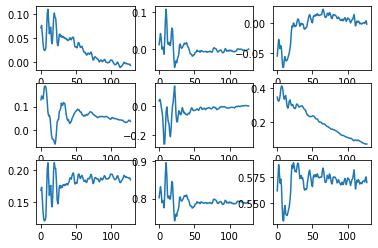

In [8]:
def plot_lines(X, nsamples):
    t = range(128)
    for i in range(9):
        plt.subplot(3,3,i+1)
        for j in range(np.minimum(X.shape[0],nsamples)):
            plt.plot(t,X[j,:,i])
    plt.show()
    
plot_lines(X_train_per_class[5], 1)

In [9]:
# Input Data
training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
means = np.mean(X_train, axis=(0,1))
stdevs = np.std(X_train, axis=(0,1))

print("X shape, Y_shape:")
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
print()
print("Mean / Stdev for each feature:")
for i in range(9):
    print("%7.4f | %7.4f"%(means[i], stdevs[i]))

X shape, Y_shape:
(7352, 128, 9) (7352, 6)
(2947, 128, 9) (2947, 6)

Mean / Stdev for each feature:
-0.0006 |  0.1948
-0.0003 |  0.1224
-0.0003 |  0.1069
 0.0005 |  0.4068
-0.0008 |  0.3819
 0.0001 |  0.2557
 0.8047 |  0.4141
 0.0288 |  0.3910
 0.0865 |  0.3578


### Normalization

Can be skipped since the features are all at similar scales aready.

### Specify and Train the Model

Specify a model based on a SimpleRNN (keras.layers.SimpleRNN). 

Start with a model consisting of a single layer. Try different number of units.
Continue with adding more layers. Try to improve the test accuracy. 

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import LSTM, RNN, SimpleRNN, Dropout, GRU

from sklearn import metrics

In [11]:
def performance_plots(model, X_test, Y_test, log, epochs):    
    acc = log.history['accuracy']
    val_acc = log.history['val_accuracy']
    print('Train accuracy (max):', acc[-1])
    print('Train accuracy (end):', np.max(acc))
    print('Test accuracy (end) :', val_acc[-1])
    print('Test accuracy (end) :', np.max(val_acc))

    plt.plot(log.history['accuracy'])
    plt.plot(log.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.axis([0,epochs,0.0,1.0])
    plt.show()

    plt.plot(log.history['loss'])
    plt.plot(log.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc = 'upper left')
    plt.axis([0,epochs,0.0,2.0])
    plt.show()

In [12]:
import sklearn
import pandas as pd
activities = ["walk", "up", "down", "sit", "stand", "lay"]

def confusion_matrix(model, X_test, Y_test):
    scores = model.predict(X_test)
    predictions = np.argmax(scores, axis=1)
    labels = np.argmax(Y_test, axis=1)
    cm = sklearn.metrics.confusion_matrix(labels, predictions)
    df = pd.DataFrame({activities[i] : cm[:,i] for i in range(len(activities))}, activities)
    return df

### Single Layer RNN

In [14]:
tf.keras.layers.SimpleRNN?

In [19]:
# create and compile model 

n_steps    = len(X_train[0])     # 128 timesteps per series
n_input    = len(X_train[0][0])  # 9 input features per timestep
n_classes  = 6 # Total classes

### START YOUR CODE 

n_hidden   = 128
batch_size = 32
n_epochs   = 20

model = Sequential([
    SimpleRNN(n_hidden, input_shape=(n_steps,n_input)),
    Dense(n_classes, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam',
             metrics=['accuracy'])

### END YOUR CODE 

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (None, 128)               17664     
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 774       
Total params: 18,438
Trainable params: 18,438
Non-trainable params: 0
_________________________________________________________________


In [20]:
# train the model
log = model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_test, Y_test))

Train on 7352 samples, validate on 2947 samples
Epoch 1/20
7352/7352 [==============================] - 11s 2ms/sample - loss: 1.1300 - accuracy: 0.5337 - val_loss: 0.9812 - val_accuracy: 0.6050
Epoch 2/20
7352/7352 [==============================] - 10s 1ms/sample - loss: 0.7616 - accuracy: 0.6782 - val_loss: 0.7977 - val_accuracy: 0.6451
Epoch 3/20
7352/7352 [==============================] - 10s 1ms/sample - loss: 1.0935 - accuracy: 0.5544 - val_loss: 1.0804 - val_accuracy: 0.5548
Epoch 4/20
7352/7352 [==============================] - 10s 1ms/sample - loss: 0.8690 - accuracy: 0.6280 - val_loss: 0.8676 - val_accuracy: 0.6128
Epoch 5/20
7352/7352 [==============================] - 10s 1ms/sample - loss: 0.6383 - accuracy: 0.7265 - val_loss: 0.6912 - val_accuracy: 0.7116
Epoch 6/20
7352/7352 [==============================] - 10s 1ms/sample - loss: 0.6443 - accuracy: 0.7379 - val_loss: 0.7326 - val_accuracy: 0.7296
Epoch 7/20
7352/7352 [==============================] - 10s 1ms/sample

Train accuracy (max): 0.8140642
Train accuracy (end): 0.8140642
Test accuracy (end) : 0.7885986
Test accuracy (end) : 0.7885986


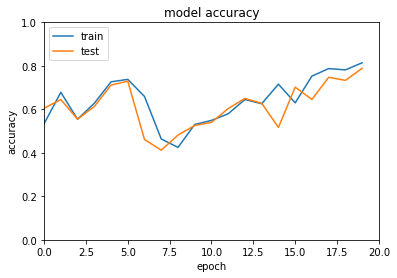

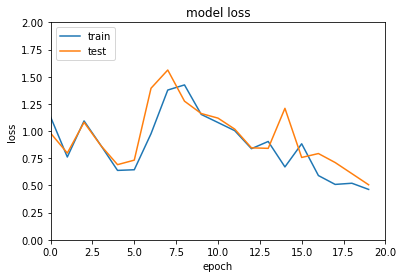

,walk,up,down,sit,stand,lay
walk,445,38,10,2,1,0
up,106,334,29,2,0,0
down,34,142,243,0,0,1
sit,4,2,1,384,100,0
stand,8,0,0,116,408,0
lay,0,0,27,0,0,510


In [21]:
performance_plots(model, X_test, Y_test, log, n_epochs)
confusion_matrix(model, X_test, Y_test)

## Further Model / Hyper Parameter Combinations

Examples:
* Stacked Simple RNNs
* LSTM and Stacked
* GRU and Stacked
* Conv1d + GlobalMaxPooling1D

For each combination, specify a cell with the model specification, one with the training and one with the evaluation (use for the latter the utilities provided).  


In [22]:
model = Sequential([
    SimpleRNN(128, input_shape=(n_steps, n_input), return_sequences=True),
    SimpleRNN(256, return_sequences=True),
    SimpleRNN(64),
    Dense(n_classes, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, 128, 128)          17664     
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 128, 256)          98560     
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 64)                20544     
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 390       
Total params: 137,158
Trainable params: 137,158
Non-trainable params: 0
_________________________________________________________________


In [23]:
# train the model
log = model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_test, Y_test))

Train on 7352 samples, validate on 2947 samples
Epoch 1/20
7352/7352 [==============================] - 29s 4ms/sample - loss: 1.2005 - accuracy: 0.4812 - val_loss: 1.3945 - val_accuracy: 0.4309
Epoch 2/20
7352/7352 [==============================] - 27s 4ms/sample - loss: 1.4237 - accuracy: 0.4162 - val_loss: 1.3484 - val_accuracy: 0.4150
Epoch 3/20
7352/7352 [==============================] - 28s 4ms/sample - loss: 1.3739 - accuracy: 0.4134 - val_loss: 1.2863 - val_accuracy: 0.4700
Epoch 4/20
7352/7352 [==============================] - 27s 4ms/sample - loss: 1.3025 - accuracy: 0.4518 - val_loss: 1.3227 - val_accuracy: 0.4564
Epoch 5/20
7352/7352 [==============================] - 33s 4ms/sample - loss: 1.2383 - accuracy: 0.4876 - val_loss: 1.3109 - val_accuracy: 0.4740
Epoch 6/20
7352/7352 [==============================] - 27s 4ms/sample - loss: 1.1909 - accuracy: 0.5175 - val_loss: 1.6226 - val_accuracy: 0.3349
Epoch 7/20
7352/7352 [==============================] - 27s 4ms/sample

Train accuracy (max): 0.5565832
Train accuracy (end): 0.5599837
Test accuracy (end) : 0.51408213
Test accuracy (end) : 0.5249406


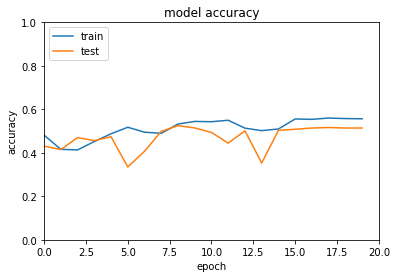

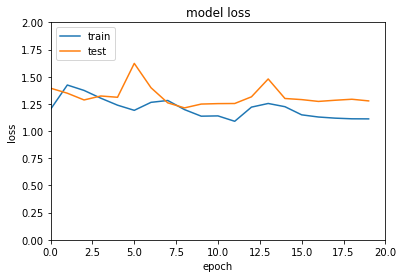

,walk,up,down,sit,stand,lay
walk,0,160,64,134,135,3
up,0,218,30,99,112,12
down,0,100,105,131,84,0
sit,0,22,2,420,47,0
stand,0,121,1,132,278,0
lay,0,27,1,15,0,494


In [24]:
performance_plots(model, X_test, Y_test, log, n_epochs)
confusion_matrix(model, X_test, Y_test)

In [34]:
def model_creator(cell_type, stacked=False):
    input_layer = tf.keras.layers.Input((n_steps, n_input))
    cell = cell_type(128, return_sequences=stacked)(input_layer)
    
    if stacked:
        cell = cell_type(256, return_sequences=stacked)(cell)
        cell = cell_type(64)(cell)
    
    output = Dense(n_classes, activation='softmax')(cell)
    
    return tf.keras.models.Model(input_layer, output)

In [28]:
lstm = model_creator(LSTM)
lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 9)]          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               70656     
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 774       
Total params: 71,430
Trainable params: 71,430
Non-trainable params: 0
_________________________________________________________________


In [29]:
# train the model
log = lstm.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_test, Y_test))

Train on 7352 samples, validate on 2947 samples
Epoch 1/20
7352/7352 [==============================] - 7s 894us/sample - loss: 1.0865 - accuracy: 0.5480 - val_loss: 1.0704 - val_accuracy: 0.6138
Epoch 2/20
7352/7352 [==============================] - 4s 536us/sample - loss: 1.1872 - accuracy: 0.5496 - val_loss: 1.2784 - val_accuracy: 0.4184
Epoch 3/20
7352/7352 [==============================] - 4s 518us/sample - loss: 1.1455 - accuracy: 0.5479 - val_loss: 1.2808 - val_accuracy: 0.5260
Epoch 4/20
7352/7352 [==============================] - 4s 521us/sample - loss: 0.7416 - accuracy: 0.7270 - val_loss: 0.7378 - val_accuracy: 0.7248
Epoch 5/20
7352/7352 [==============================] - 4s 515us/sample - loss: 0.6083 - accuracy: 0.7814 - val_loss: 0.6281 - val_accuracy: 0.7730
Epoch 6/20
7352/7352 [==============================] - 4s 503us/sample - loss: 0.5449 - accuracy: 0.7825 - val_loss: 0.5445 - val_accuracy: 0.7750
Epoch 7/20
7352/7352 [==============================] - 4s 497us

Train accuracy (max): 0.9503536
Train accuracy (end): 0.9503536
Test accuracy (end) : 0.9097387
Test accuracy (end) : 0.9097387


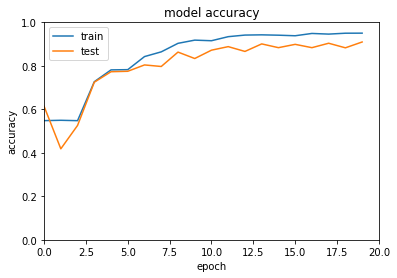

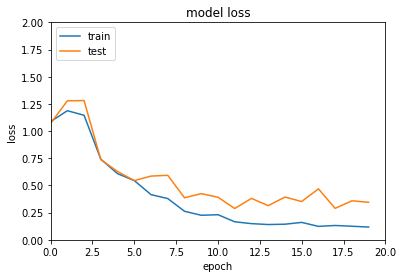

,walk,up,down,sit,stand,lay
walk,453,8,35,0,0,0
up,2,445,24,0,0,0
down,1,3,416,0,0,0
sit,0,3,0,414,74,0
stand,1,1,0,87,443,0
lay,0,27,0,0,0,510


In [31]:
performance_plots(lstm, X_test, Y_test, log, n_epochs)
confusion_matrix(lstm, X_test, Y_test)

In [35]:
lstm_stacked = model_creator(LSTM, stacked=True)
lstm_stacked.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_stacked.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 9)]          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 128, 128)          70656     
_________________________________________________________________
lstm_5 (LSTM)                (None, 128, 256)          394240    
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                82176     
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 390       
Total params: 547,462
Trainable params: 547,462
Non-trainable params: 0
_________________________________________________________________


In [36]:
# train the model
log = lstm_stacked.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_test, Y_test))

Train on 7352 samples, validate on 2947 samples
Epoch 1/20
7352/7352 [==============================] - 15s 2ms/sample - loss: 0.8055 - accuracy: 0.6585 - val_loss: 0.7637 - val_accuracy: 0.6586
Epoch 2/20
7352/7352 [==============================] - 11s 2ms/sample - loss: 0.4227 - accuracy: 0.8419 - val_loss: 0.4986 - val_accuracy: 0.8436
Epoch 3/20
7352/7352 [==============================] - 11s 1ms/sample - loss: 0.2637 - accuracy: 0.9045 - val_loss: 0.4393 - val_accuracy: 0.8612
Epoch 4/20
7352/7352 [==============================] - 11s 1ms/sample - loss: 0.2135 - accuracy: 0.9226 - val_loss: 0.3518 - val_accuracy: 0.8907
Epoch 5/20
7352/7352 [==============================] - 11s 1ms/sample - loss: 0.1897 - accuracy: 0.9295 - val_loss: 0.3316 - val_accuracy: 0.9050
Epoch 6/20
7352/7352 [==============================] - 11s 1ms/sample - loss: 0.1555 - accuracy: 0.9416 - val_loss: 0.3571 - val_accuracy: 0.8884
Epoch 7/20
7352/7352 [==============================] - 11s 1ms/sample

Train accuracy (max): 0.9436888
Train accuracy (end): 0.9545702
Test accuracy (end) : 0.8822531
Test accuracy (end) : 0.9093994


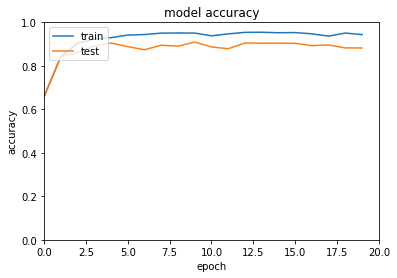

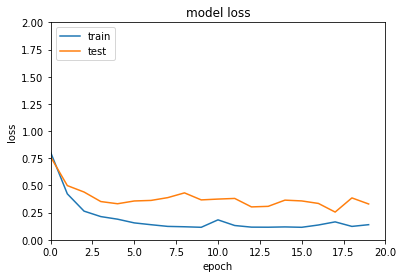

,walk,up,down,sit,stand,lay
walk,483,7,6,0,0,0
up,72,372,24,0,3,0
down,11,11,398,0,0,0
sit,0,0,0,441,50,0
stand,0,0,0,136,396,0
lay,0,0,0,0,27,510


In [37]:
performance_plots(lstm_stacked, X_test, Y_test, log, n_epochs)
confusion_matrix(lstm_stacked, X_test, Y_test)

In [38]:
gru = model_creator(GRU, stacked=False)
gru.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
gru.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 9)]          0         
_________________________________________________________________
gru (GRU)                    (None, 128)               53376     
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 774       
Total params: 54,150
Trainable params: 54,150
Non-trainable params: 0
_________________________________________________________________


In [39]:
# train the model
log = gru.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_test, Y_test))

Train on 7352 samples, validate on 2947 samples
Epoch 1/20
7352/7352 [==============================] - 5s 663us/sample - loss: 1.0618 - accuracy: 0.5585 - val_loss: 0.9253 - val_accuracy: 0.6091
Epoch 2/20
7352/7352 [==============================] - 4s 529us/sample - loss: 0.4140 - accuracy: 0.8496 - val_loss: 0.3772 - val_accuracy: 0.8778
Epoch 3/20
7352/7352 [==============================] - 4s 479us/sample - loss: 0.1953 - accuracy: 0.9287 - val_loss: 0.3782 - val_accuracy: 0.8666
Epoch 4/20
7352/7352 [==============================] - 4s 538us/sample - loss: 0.1430 - accuracy: 0.9410 - val_loss: 0.2690 - val_accuracy: 0.8931
Epoch 5/20
7352/7352 [==============================] - 4s 522us/sample - loss: 0.1397 - accuracy: 0.9436 - val_loss: 0.2697 - val_accuracy: 0.9050
Epoch 6/20
7352/7352 [==============================] - 4s 525us/sample - loss: 0.1255 - accuracy: 0.9445 - val_loss: 0.2651 - val_accuracy: 0.9226
Epoch 7/20
7352/7352 [==============================] - 4s 503us

Train accuracy (max): 0.9547062
Train accuracy (end): 0.95525026
Test accuracy (end) : 0.93281305
Test accuracy (end) : 0.934849


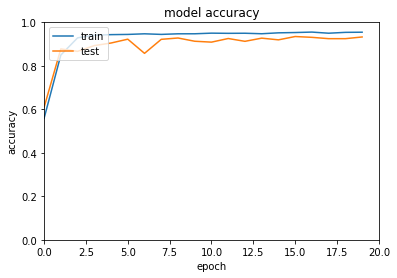

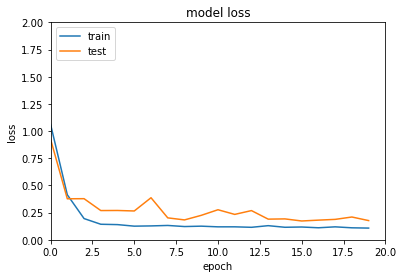

,walk,up,down,sit,stand,lay
walk,496,0,0,0,0,0
up,6,465,0,0,0,0
down,1,0,419,0,0,0
sit,4,1,0,375,111,0
stand,0,0,0,75,457,0
lay,0,0,0,0,0,537


In [40]:
performance_plots(gru, X_test, Y_test, log, n_epochs)
confusion_matrix(gru, X_test, Y_test)

In [41]:
gru_stacked = model_creator(GRU, stacked=True)
gru_stacked.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
gru_stacked.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 128, 9)]          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 128, 128)          53376     
_________________________________________________________________
gru_2 (GRU)                  (None, 128, 256)          296448    
_________________________________________________________________
gru_3 (GRU)                  (None, 64)                61824     
_________________________________________________________________
dense_9 (Dense)              (None, 6)                 390       
Total params: 412,038
Trainable params: 412,038
Non-trainable params: 0
_________________________________________________________________


In [42]:
# train the model
log = gru_stacked.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_test, Y_test))

Train on 7352 samples, validate on 2947 samples
Epoch 1/20
7352/7352 [==============================] - 15s 2ms/sample - loss: 0.6478 - accuracy: 0.7437 - val_loss: 0.4191 - val_accuracy: 0.8643
Epoch 2/20
7352/7352 [==============================] - 11s 1ms/sample - loss: 0.1715 - accuracy: 0.9343 - val_loss: 0.3370 - val_accuracy: 0.8761
Epoch 3/20
7352/7352 [==============================] - 11s 1ms/sample - loss: 0.1565 - accuracy: 0.9361 - val_loss: 0.3055 - val_accuracy: 0.9043
Epoch 4/20
7352/7352 [==============================] - 9s 1ms/sample - loss: 0.1427 - accuracy: 0.9404 - val_loss: 0.2734 - val_accuracy: 0.9009
Epoch 5/20
7352/7352 [==============================] - 7s 945us/sample - loss: 0.1338 - accuracy: 0.9475 - val_loss: 0.2688 - val_accuracy: 0.9141
Epoch 6/20
7352/7352 [==============================] - 7s 934us/sample - loss: 0.1169 - accuracy: 0.9516 - val_loss: 0.2678 - val_accuracy: 0.9175
Epoch 7/20
7352/7352 [==============================] - 7s 960us/samp

Train accuracy (max): 0.960691
Train accuracy (end): 0.960691
Test accuracy (end) : 0.9195792
Test accuracy (end) : 0.92568713


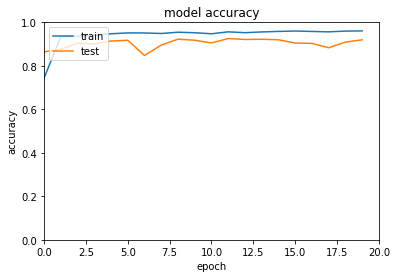

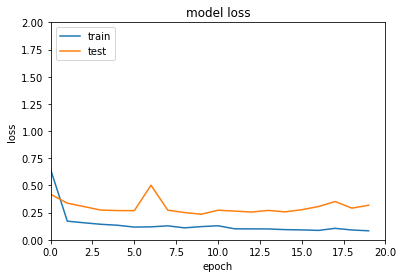

,walk,up,down,sit,stand,lay
walk,463,9,24,0,0,0
up,9,462,0,0,0,0
down,0,0,420,0,0,0
sit,0,2,2,392,92,3
stand,0,0,0,96,436,0
lay,0,0,0,0,0,537


In [43]:
performance_plots(gru_stacked, X_test, Y_test, log, n_epochs)
confusion_matrix(gru_stacked, X_test, Y_test)

In [45]:
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D

In [48]:
GlobalMaxPooling1D?

In [69]:
model = Sequential([
    Conv1D(256, kernel_size=7, input_shape=(n_steps, n_input), activation='relu'),
#    GlobalMaxPooling1D(),
    Conv1D(128, kernel_size=5, activation='relu'),
#    GlobalMaxPooling1D(),
    Conv1D(64, kernel_size=3, activation='relu'),
    GlobalMaxPooling1D(),
#    tf.keras.layers.Flatten(),
    Dense(n_classes, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_41 (Conv1D)           (None, 122, 256)          16384     
_________________________________________________________________
conv1d_42 (Conv1D)           (None, 118, 128)          163968    
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 116, 64)           24640     
_________________________________________________________________
global_max_pooling1d_29 (Glo (None, 64)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 6)                 390       
Total params: 205,382
Trainable params: 205,382
Non-trainable params: 0
_________________________________________________________________


In [70]:
# train the model
log = model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_test, Y_test))

Train on 7352 samples, validate on 2947 samples
Epoch 1/20
7352/7352 [==============================] - 3s 359us/sample - loss: 0.2699 - accuracy: 0.9023 - val_loss: 0.2940 - val_accuracy: 0.8819
Epoch 2/20
7352/7352 [==============================] - 2s 277us/sample - loss: 0.1092 - accuracy: 0.9566 - val_loss: 0.2581 - val_accuracy: 0.9043
Epoch 3/20
7352/7352 [==============================] - 2s 267us/sample - loss: 0.0997 - accuracy: 0.9591 - val_loss: 0.2126 - val_accuracy: 0.9206
Epoch 4/20
7352/7352 [==============================] - 2s 273us/sample - loss: 0.0930 - accuracy: 0.9634 - val_loss: 0.2430 - val_accuracy: 0.9067
Epoch 5/20
7352/7352 [==============================] - 2s 279us/sample - loss: 0.0793 - accuracy: 0.9690 - val_loss: 0.2998 - val_accuracy: 0.9108
Epoch 6/20
7352/7352 [==============================] - 2s 288us/sample - loss: 0.0942 - accuracy: 0.9652 - val_loss: 0.6559 - val_accuracy: 0.8629
Epoch 7/20
7352/7352 [==============================] - 2s 281us

Train accuracy (max): 0.98911864
Train accuracy (end): 0.9907508
Test accuracy (end) : 0.91720396
Test accuracy (end) : 0.94265354


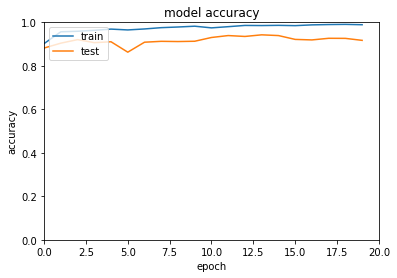

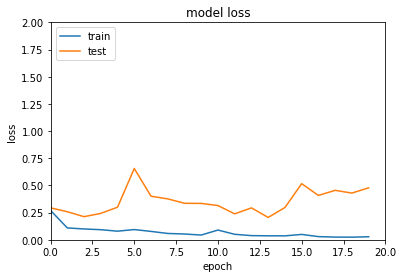

,walk,up,down,sit,stand,lay
walk,462,27,4,3,0,0
up,34,411,26,0,0,0
down,1,3,414,0,2,0
sit,0,4,0,395,92,0
stand,1,0,0,20,511,0
lay,23,1,0,0,3,510


In [71]:
performance_plots(model, X_test, Y_test, log, n_epochs)
confusion_matrix(model, X_test, Y_test)

## Report with your Findings

We can observe here that the LSTM models perform worse in comparison with GRUs and especially with Conv1D models. Interestingly, the Single-GRU-layered model performed better than the stacked GRU model, but no really hint of overfitting is present there.

However when looking at the plots of the Conv1D model we could observe a slight hint of overfitting as the cost function values on the test set increased in the last 8 epochs whereas the performance on the test set may decreased to a small amount.

The LSTMs performed worst compared to GRU and Conv1D. Maybe they need more training epochs.